## Model for Student Housing - Exchange

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load the dataset
df = pd.read_csv('../data/preprocessed/df_agg_area.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1097 non-null   object
 1   vacancies    1097 non-null   int64 
 2   area_BROCK   1097 non-null   int64 
 3   area_EXCH    1097 non-null   int64 
 4   area_FRASER  1097 non-null   int64 
 5   area_GREEN   1097 non-null   int64 
 6   area_IONA    1097 non-null   int64 
 7   area_KWTQ    1097 non-null   int64 
 8   area_MARINE  1097 non-null   int64 
 9   area_POND    1097 non-null   int64 
 10  area_STJOHN  1097 non-null   int64 
 11  area_TBIRD   1097 non-null   int64 
 12  area_AP_UA   1097 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 111.5+ KB


In [4]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Rename column 'date' to Prophet's format
df.rename(columns={'date': 'ds'}, inplace=True)
df.head()

,ds,vacancies,area_BROCK,area_EXCH,area_FRASER,area_GREEN,area_IONA,area_KWTQ,area_MARINE,area_POND,area_STJOHN,area_TBIRD,area_AP_UA
0,2021-11-01,74,1,5,2,7,0,0,23,6,2,11,17
1,2021-11-02,91,2,5,2,7,0,0,25,7,5,12,26
2,2021-11-03,93,2,5,2,7,0,0,25,7,4,13,28
3,2021-11-04,95,2,5,2,7,0,0,26,7,5,13,28
4,2021-11-05,93,2,5,2,7,0,0,26,7,5,12,27


In [6]:
# Melt the dataframe to convert from wide to long format
df_long = df.melt(id_vars=['ds'], var_name='area', value_name='y')

# Preview the melted data
df_long.head()

,ds,area,y
0,2021-11-01,vacancies,74
1,2021-11-02,vacancies,91
2,2021-11-03,vacancies,93
3,2021-11-04,vacancies,95
4,2021-11-05,vacancies,93


In [7]:
# Display max vacancies per month 

# Define the area
area ='area_EXCH'

# Extract year and month to group by month
df['year_month'] = df['ds'].dt.to_period('M')

# Find the date with the maximum vacancies for each month
idx = df.groupby('year_month')[area].idxmax()

# Retrieve the rows with the maximum vacancies
max_vacancy_per_month = df.loc[idx, ['ds', 'year_month', area]].reset_index(drop=True)

# Rename columns for clarity
max_vacancy_per_month.rename(columns={'ds': 'Date', 'year_month': 'Month', area: 'Max Exchange Vacancies'}, inplace=True)

# Display the result
print(max_vacancy_per_month)

         Date    Month  Max Exchange Vacancies
0  2021-11-01  2021-11                       5
1  2021-12-25  2021-12                      31
2  2022-01-01  2022-01                      33
3  2022-02-02  2022-02                      14
4  2022-03-02  2022-03                       8
5  2022-04-30  2022-04                     197
6  2022-05-03  2022-05                     210
7  2022-06-06  2022-06                      35
8  2022-07-02  2022-07                      11
9  2022-08-22  2022-08                      10
10 2022-09-03  2022-09                      11
11 2022-10-13  2022-10                       6
12 2022-11-02  2022-11                       3
13 2022-12-29  2022-12                      20
14 2023-01-02  2023-01                      15
15 2023-02-09  2023-02                       1
16 2023-03-06  2023-03                       2
17 2023-04-30  2023-04                     152
18 2023-05-02  2023-05                     156
19 2023-06-05  2023-06                      58
20 2023-07-04

### 1. Basic prediction

In [8]:
# Define holidays - Move out days for Student Housing - Year Round contract is around end of April each year plus since 2023 we allow students to stay until graduation (beginning of June)
holidays = pd.DataFrame({
  'holiday': 'move_out',
  'ds': pd.to_datetime(['2022-04-28', '2023-04-29', '2024-04-28', '2023-06-04', '2024-05-31']),  # move-out dates
    'lower_window': [0, 0, 0, -3, -3],
    'upper_window': [6, 6, 6, 3, 3]
})

In [9]:
# Define the area for model
area = 'area_EXCH'  

# Rename columns for Prophet
df_exch = df[['ds', area]].rename(columns={area: 'y'})

# Initialize the Prophet model with specified hyperparameters
# - 'holidays' provides holiday information to the model
# - 'yearly_seasonality=30' increases flexibility for capturing yearly trends
# - 'changepoint_prior_scale' controls sensitivity to changepoints
# - 'seasonality_mode' defines how seasonal effects are modeled (here additive)
model = Prophet(holidays=holidays, 
                yearly_seasonality=30,
                changepoint_prior_scale=0.05,
                seasonality_prior_scale=15,
                seasonality_mode='additive')

# Fit the model
model.fit(df_exch)

# Predict on future (1 year in the future)
future = model.make_future_dataframe(periods=365)

# Generate predictions for the future
forecast = model.predict(future)

# Clip the predicted values to ensure no negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

20:43:32 - cmdstanpy - INFO - Chain [1] start processing
20:43:33 - cmdstanpy - INFO - Chain [1] done processing


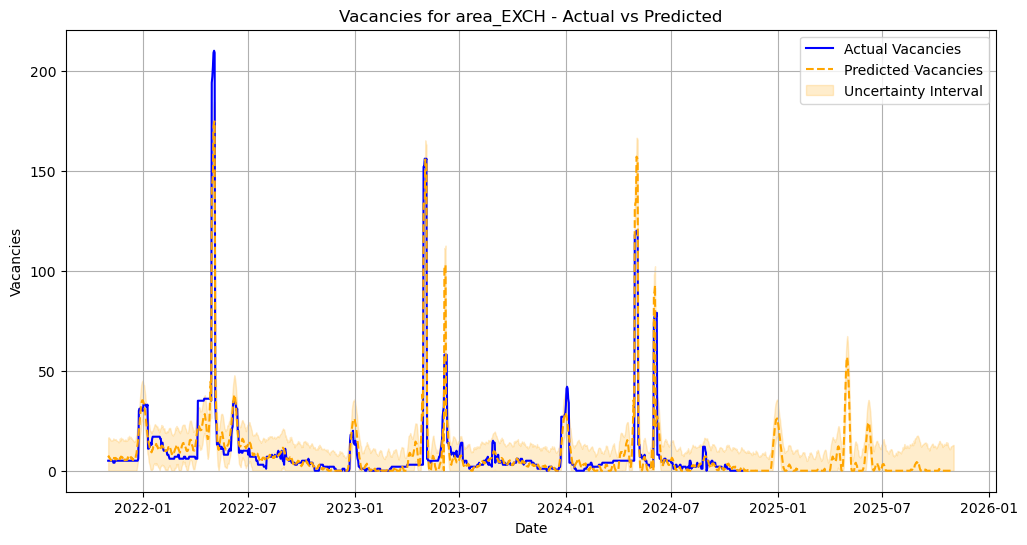

In [10]:
# Plot the forecast with actual values
plt.figure(figsize=(12, 6))
plt.plot(df_exch['ds'], 
         df_exch['y'], 
         label="Actual Vacancies", 
         color='blue'
        )
plt.plot(forecast['ds'], 
         forecast['yhat'], 
         label="Predicted Vacancies", 
         color='orange', 
         linestyle='--'
        )
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='orange', 
                 alpha=0.2, 
                 label="Uncertainty Interval"
                )
plt.title(f"Vacancies for {area} - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.savefig('../plots/before-tuning/forecasted_exch-before.png', dpi=300, bbox_inches='tight')
plt.show()

### 2. Cross Validation

In [11]:
# Perform cross-validation
# - 'initial' - the training period, here 730 days = 2 years
# - 'period' - the spacing between validation sets, here 180 days = 0.5 year
# - 'horizon' - the forecast horizon, here 365 days = 1 year
cv = cross_validation(model,
                      initial='730 days',
                      period='180 days', 
                      horizon='365 days')

# Calculate performance metrics (MAE, MSE, RMSE)
# Evaluate errors
mae = mean_absolute_error(cv['y'], cv['yhat'])
mse = mean_squared_error(cv['y'], cv['yhat'])
rmse = np.sqrt(mse)

# Print metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 20.41
Mean Squared Error: 545.39
Root Mean Squared Error: 23.35


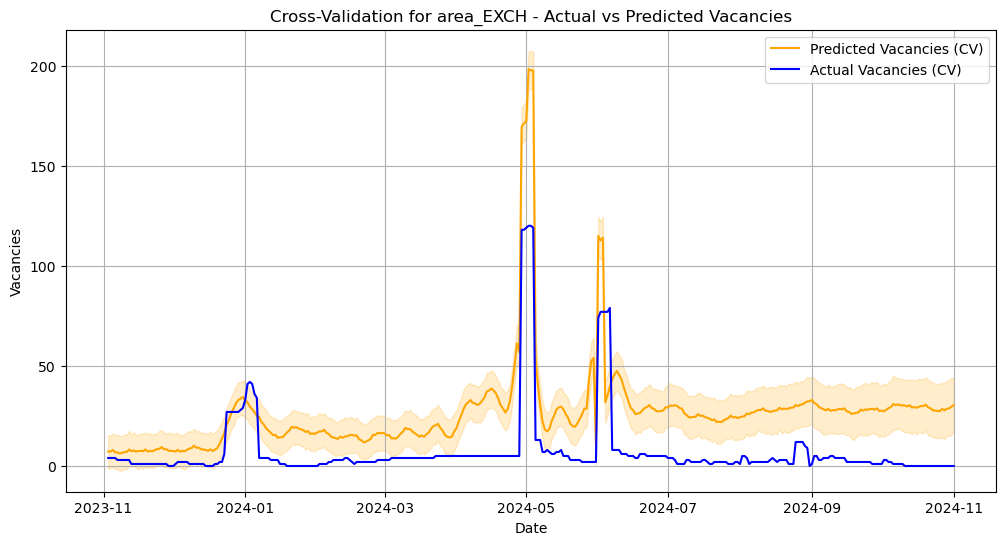

In [12]:
# Plot cross validation results:
plt.figure(figsize=(12, 6))
plt.plot(cv['ds'], 
         cv['yhat'], 
         label="Predicted Vacancies (CV)", 
         color='orange'
        )
plt.plot(cv['ds'],
         cv['y'], 
         label="Actual Vacancies (CV)", 
         color='blue'
        )
plt.fill_between(cv['ds'], 
                 cv['yhat_lower'],
                 cv['yhat_upper'], 
                 color='orange',
                 alpha=0.2
                )
plt.title(f"Cross-Validation for {area} - Actual vs Predicted Vacancies")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.show()

### 3. Hyperparameter Tuning

In [13]:
from itertools import product

# Define a grid of hyperparameters
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1, 10],
    'yearly_seasonality': [10, 20, 30]
}

# Generate all combinations of hyperparameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())] # generated with chatGPT 

# List to store results
param_results = []

# Iterate through each combination of parameters
for params in all_params:
    print(f"Testing parameters: {params}")
    
    # Initialize and fit the model with the current parameters
    model = Prophet(
        holidays=holidays, 
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        yearly_seasonality=params['yearly_seasonality'],
        seasonality_mode='additive'
    )
    model.fit(df_exch)
    
    # Perform cross-validation
    cv_hp = cross_validation(
        model, 
        initial='730 days', 
        period='180 days', 
        horizon='365 days'
    )
    
    # Compute metrics
    metrics = performance_metrics(cv_hp)
    param_results.append((params, metrics['rmse'].mean()))

# Find the best parameters based on RMSE
best_params = min(param_results, key=lambda x: x[1])
print(f"Best parameters: {best_params[0]} with RMSE: {best_params[1]:.2f}")

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10}


20:43:37 - cmdstanpy - INFO - Chain [1] start processing
20:43:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:38 - cmdstanpy - INFO - Chain [1] start processing
20:43:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 20}


20:43:40 - cmdstanpy - INFO - Chain [1] start processing
20:43:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:40 - cmdstanpy - INFO - Chain [1] start processing
20:43:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 30}


20:43:41 - cmdstanpy - INFO - Chain [1] start processing
20:43:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:42 - cmdstanpy - INFO - Chain [1] start processing
20:43:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'yearly_seasonality': 10}


20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'yearly_seasonality': 20}


20:43:45 - cmdstanpy - INFO - Chain [1] start processing
20:43:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:45 - cmdstanpy - INFO - Chain [1] start processing
20:43:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'yearly_seasonality': 30}


20:43:46 - cmdstanpy - INFO - Chain [1] start processing
20:43:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:46 - cmdstanpy - INFO - Chain [1] start processing
20:43:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10}


20:43:47 - cmdstanpy - INFO - Chain [1] start processing
20:43:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:48 - cmdstanpy - INFO - Chain [1] start processing
20:43:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10, 'yearly_seasonality': 20}


20:43:49 - cmdstanpy - INFO - Chain [1] start processing
20:43:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:50 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10, 'yearly_seasonality': 30}


20:43:51 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:51 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10}


20:43:52 - cmdstanpy - INFO - Chain [1] start processing
20:43:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:52 - cmdstanpy - INFO - Chain [1] start processing
20:43:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 20}


20:43:53 - cmdstanpy - INFO - Chain [1] start processing
20:43:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:54 - cmdstanpy - INFO - Chain [1] start processing
20:43:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 30}


20:43:55 - cmdstanpy - INFO - Chain [1] start processing
20:43:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:55 - cmdstanpy - INFO - Chain [1] start processing
20:43:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'yearly_seasonality': 10}


20:43:56 - cmdstanpy - INFO - Chain [1] start processing
20:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:57 - cmdstanpy - INFO - Chain [1] start processing
20:43:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'yearly_seasonality': 20}


20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'yearly_seasonality': 30}


20:43:59 - cmdstanpy - INFO - Chain [1] start processing
20:43:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:43:59 - cmdstanpy - INFO - Chain [1] start processing
20:43:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10}


20:44:00 - cmdstanpy - INFO - Chain [1] start processing
20:44:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'yearly_seasonality': 20}


20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:02 - cmdstanpy - INFO - Chain [1] start processing
20:44:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'yearly_seasonality': 30}


20:44:03 - cmdstanpy - INFO - Chain [1] start processing
20:44:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:03 - cmdstanpy - INFO - Chain [1] start processing
20:44:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10}


20:44:04 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 20}


20:44:06 - cmdstanpy - INFO - Chain [1] start processing
20:44:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:06 - cmdstanpy - INFO - Chain [1] start processing
20:44:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 30}


20:44:07 - cmdstanpy - INFO - Chain [1] start processing
20:44:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:08 - cmdstanpy - INFO - Chain [1] start processing
20:44:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'yearly_seasonality': 10}


20:44:09 - cmdstanpy - INFO - Chain [1] start processing
20:44:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:10 - cmdstanpy - INFO - Chain [1] start processing
20:44:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'yearly_seasonality': 20}


20:44:11 - cmdstanpy - INFO - Chain [1] start processing
20:44:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:12 - cmdstanpy - INFO - Chain [1] start processing
20:44:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'yearly_seasonality': 30}


20:44:12 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10}


20:44:14 - cmdstanpy - INFO - Chain [1] start processing
20:44:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:14 - cmdstanpy - INFO - Chain [1] start processing
20:44:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'yearly_seasonality': 20}


20:44:15 - cmdstanpy - INFO - Chain [1] start processing
20:44:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:16 - cmdstanpy - INFO - Chain [1] start processing
20:44:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'yearly_seasonality': 30}


20:44:17 - cmdstanpy - INFO - Chain [1] start processing
20:44:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

20:44:17 - cmdstanpy - INFO - Chain [1] start processing
20:44:18 - cmdstanpy - INFO - Chain [1] done processing


Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'yearly_seasonality': 30} with RMSE: 9.70


### Final evaluation with best parameters

In [14]:
# Train the model with the best parameters
best_model = Prophet(
    holidays=holidays,
    changepoint_prior_scale=best_params[0]['changepoint_prior_scale'],
    seasonality_prior_scale=best_params[0]['seasonality_prior_scale'],
    yearly_seasonality=best_params[0]['yearly_seasonality'],
    seasonality_mode='additive'
)

best_model.fit(df_exch)

# Predict and visualize using the best model
future = best_model.make_future_dataframe(periods=365)
forecast = best_model.predict(future)

# Clip the predicted values to ensure no negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

20:44:18 - cmdstanpy - INFO - Chain [1] start processing
20:44:19 - cmdstanpy - INFO - Chain [1] done processing


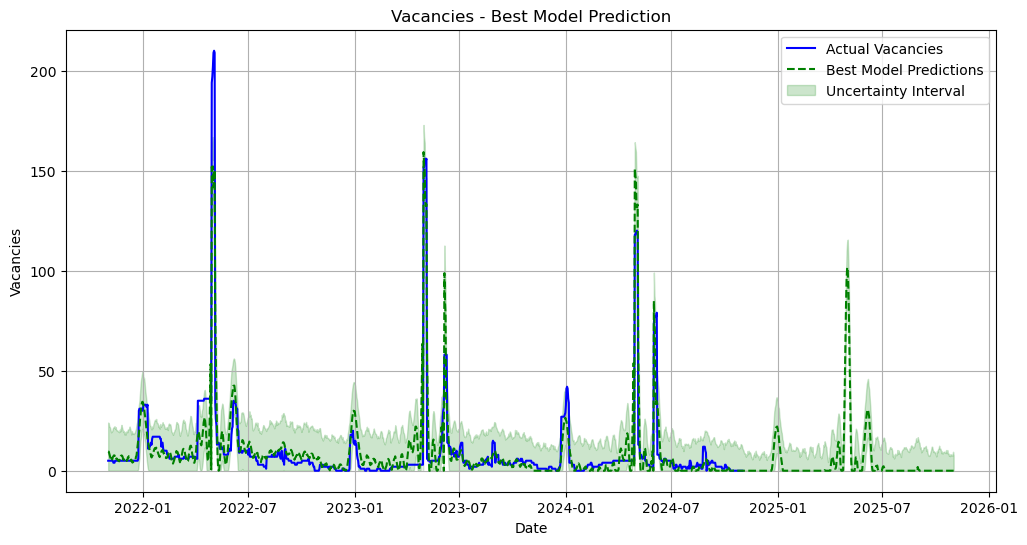

In [15]:
# Plot final forecast
plt.figure(figsize=(12, 6))
plt.plot(df_exch['ds'], 
         df_exch['y'], 
         label="Actual Vacancies", 
         color='blue'
        )
plt.plot(forecast['ds'],
         forecast['yhat'], 
         label="Best Model Predictions",
         color='green', 
         linestyle='--'
        )
plt.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='green', alpha=0.2, label="Uncertainty Interval"
)
plt.title("Vacancies - Best Model Prediction")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.savefig('../plots/after-tuning/forecasted_exch-after.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
forecast.to_csv('../data/predictions/forecast_exch.csv', index = False)
df_exch.to_csv('../data/predictions/df_exch.csv', index = False)